<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pyodbc
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import re
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 500)
sns.set()

In [2]:
# Connect to Access Database and access data with SQL commands
access_database = r'C:\Users\thwhi\Dropbox\Personal\Programming\Aircraft Stuff\avall_full_aircraft_crash_database\avall.mdb'
driver = r'Microsoft Access Driver (*.mdb, *.accdb)'
conn = pyodbc.connect(r'DRIVER={' + driver + '};DBQ=' + access_database + ';')

In [3]:
# Import data dictionary which has what the different codes in cells actually
# mean. The ct_iaids also contains similar coding information

df_data_dictionary = pd.read_sql_query('SELECT * FROM eADMSPUB_DataDictionary',conn)
df_ct_iaids = pd.read_sql_query('SELECT * FROM ct_iaids',conn)

In [4]:
# Import several of the important tables. For now I just imported the whole table, but in the future
# I might select a subset of variables to look at. Without knowing quite which variables are 
# important, I decided to have them all available for ease of analysis. 
df_events = pd.read_sql_query('SELECT * FROM events',conn)
df_aircraft = pd.read_sql_query('SELECT * FROM aircraft',conn)
df_engines = pd.read_sql_query('SELECT * FROM engines',conn)
df_flight_crew = pd.read_sql_query('SELECT * FROM Flight_Crew',conn)
df_flight_time = pd.read_sql_query('SELECT * FROM flight_time',conn)
df_findings = pd.read_sql_query('SELECT * FROM Findings',conn)
df_occurrences = pd.read_sql_query('SELECT * FROM OCCURRENCES',conn)

In [5]:
# Function to remove duplicates, set all values to uppercase, and to strip all entries of leading and trailing spaces
def strip_strings(df):
    df = df.loc[:,~df.columns.duplicated()]
    df = df.dropna(axis=1,how='all')
    for col in df.columns:
        if df[col].dtype=='O':
            df[col] = df[col].str.strip()
        if df[col].dtype=='O':
            df[col] = df[col].str.upper()
    return(df)

In [6]:
# Apply that function to each of the tables from that database
df_events = strip_strings(df_events)
df_aircraft = strip_strings(df_aircraft)
df_engines = strip_strings(df_engines)
df_flight_crew = strip_strings(df_flight_crew)
df_flight_time = strip_strings(df_flight_time)
df_findings = strip_strings(df_findings)
df_occurrences = strip_strings(df_occurrences)

In [7]:
# Remove any non-GA records from the events table. This will trickle down to all the other tables which always use
# df_events.
ga_far_parts = ['091','091K','125','133','137']
df_events = df_events.merge(df_aircraft[['ev_id','far_part']],how='left',left_on='ev_id',right_on='ev_id')
df_events = df_events[df_events['far_part'].isin(ga_far_parts)]

In [8]:
# Set total flight hours values listed as above 95000 to NaN, as they are almost certainly mis-entries
df_flight_time['flight_hours'] = df_flight_time['flight_hours'].apply(lambda x: np.nan if x > 95000 else x)

In [9]:
# Function to merge dfs in the most common fashion
def merge_dfs(df2,field):
    df = df_events[['ev_id','ev_highest_injury']].merge(df2[['ev_id',field]],how='left',left_on='ev_id',right_on='ev_id')
    return(df)

In [10]:
# Function to plot the most common type of comparison I'm doing in this analysis
def plot_ratio_by_field(df,field,name,sort=False):

    df_rate = df.groupby([field,'ev_highest_injury']).size().unstack(fill_value=0)
    df_rate['TOTL'] = df_rate.sum(axis=1)
    df_rate['FATL_Ratio'] = df_rate['FATL']/df_rate['TOTL']
    if sort:
        df_rate = df_rate.sort_values('FATL_Ratio',ascending=False)

    fig,ax = plt.subplots()
    fig.set_size_inches(8,6)
    df_rate['FATL_Ratio'].plot.bar(ax=ax)
    ax.set_title('Ratio of Fatal Accidents to Total Accidents by {}\n1982 - Present'.format(name),fontsize=16)
    ax.set_ylabel('Ratio',fontsize=14)
    ax.set_xlabel(name,fontsize=14)
    a=ax.set_xticklabels(df_rate.index,rotation=0)
    
    return(fig,ax)

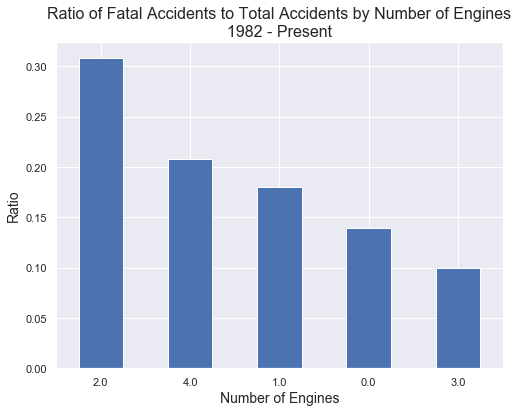

In [11]:
df = merge_dfs(df_aircraft,'num_eng')
fig,ax = plot_ratio_by_field(df,'num_eng','Number of Engines',sort=True)

In [12]:
df.head()

,ev_id,ev_highest_injury,num_eng
0,20001208X07734,FATL,1.0
1,20021008X05297,SERS,1.0
2,20040127X00111,NONE,1.0
3,20181125X85246,NONE,1.0
4,20001213X34369,NONE,1.0


In [13]:
df_aircraft.head()

,ev_id,Aircraft_Key,regis_no,ntsb_no,acft_missing,far_part,flt_plan_filed,flight_plan_activated,damage,acft_fire,acft_expl,acft_make,acft_model,acft_series,acft_serial_no,cert_max_gr_wt,acft_category,acft_reg_cls,homebuilt,fc_seats,cc_seats,pax_seats,total_seats,num_eng,fixed_retractable,type_last_insp,date_last_insp,afm_hrs_last_insp,afm_hrs,elt_install,elt_oper,elt_aided_loc_ev,elt_type,owner_acft,owner_street,owner_city,owner_state,owner_country,owner_zip,oper_individual_name,oper_name,oper_same,oper_dba,oper_addr_same,oper_street,oper_city,oper_state,oper_country,oper_zip,oper_code,certs_held,oprtng_cert,oper_cert,oper_cert_num,oper_sched,oper_dom_int,oper_pax_cargo,type_fly,second_pilot,dprt_pt_same_ev,dprt_apt_id,dprt_city,dprt_state,dprt_country,dprt_time,dprt_timezn,dest_same_local,dest_apt_id,dest_city,dest_state,dest_country,phase_flt_spec,report_to_icao,evacuation,lchg_date,lchg_userid,afm_hrs_since,rwy_num,rwy_len,rwy_width,site_seeing,air_medical,med_type_flight,acft_year,commercial_space_flight,unmanned,ifr_equipped_cert,elt_mounted_aircraft,elt_connected_antenna
0,20001208X07734,1,N6172C,LAX97FA143,N,091,IFR,None,DEST,NONE,NONE,CESSNA,T210N,T210N,210-63820,3800.0,AIR,USUS,N,NaN,NaN,NaN,6.0,1.0,RETR,ANNL,1996-11-16,34.0,1643.0,Y,U,U,None,JAMES E. ELDREDGE,4039 KNOLL RIDGE AVE.,LAS VEGAS,NV,,89030,None,,Y,RANGER ENTERPRISES,Y,,,,,,,N,N,UNK,None,None,None,None,PERS,N,N,LVS,LAS VEGAS,NM,,1750.0,MST,LOCL,VGT,,NV,,540.0,None,None,2001-01-02 10:34:39,DBO,None,0,NaN,NaN,N,N,None,NaN,False,False,False,False,False
1,20021008X05297,1,N9714W,CHI02LA299,None,091,NONE,N,SUBS,NONE,NONE,PIPER,PA-28-140,None,28-23190,2150.0,AIR,USUS,N,NaN,NaN,NaN,4.0,1.0,None,None,NaT,NaN,4700.0,Y,U,N,None,WEST CENTRAL AIRWAYS INC,4005 HIGHWAY 210 W,FERGUS FALLS,MN,USA,56537,N,None,Y,None,Y,None,None,None,None,None,IIQA,N,None,None,None,None,None,None,INST,Y,N,04Y,HAWLEY,MN,USA,2045.0,CDT,SAME,JKJ,MOOREHEAD,MN,USA,570.0,None,N,2003-03-13 11:39:24,SULP,ACCI,12,4000.0,75.0,N,N,None,NaN,False,False,False,False,False
2,20040127X00111,1,N7127V,LAX04LA103,None,091,VFR,Y,SUBS,NONE,NONE,MOONEY,20F,None,22-0056,2740.0,AIR,USUS,N,NaN,NaN,NaN,4.0,1.0,RETR,ANNL,2003-01-10,120.0,4120.0,Y,N,N,None,THOMAS CHENAL,None,SCOTTSDALE,AZ,USA,85254,N,None,Y,None,Y,None,None,None,None,None,None,N,None,None,None,None,None,None,PERS,N,N,SFA,SANTA FE,NM,USA,1500.0,CST,SAME,SDL,SCOTTSDALE,AZ,USA,570.0,N,N,NaT,None,ACCI,21,8251.0,75.0,N,N,None,NaN,False,False,False,False,False
3,20181125X85246,1,N66710,GAA19CA073,None,091,NONE,U,SUBS,NONE,NONE,BEECH,C23,None,M-2387,2450.0,AIR,None,N,2.0,NaN,2.0,4.0,1.0,None,ANNL,2017-11-20,NaN,6109.0,Y,N,U,C91,"DONALD UTTENREITHER, RICKEY COOKSEY",None,PORTERVILLE,CA,USA,932579130,Y,RICKEY COOKSEY,N,None,Y,None,PORTERVILLE,CA,USA,932579130,None,Y,None,None,None,None,None,None,PERS,N,N,PTV,PORTERVILLE,CA,USA,1250.0,PST,LOCL,PTV,PORTERVILLE,CA,USA,NaN,None,None,2018-12-21 17:23:10,GUTE,INSP,30,5960.0,150.0,N,N,None,1983.0,False,False,False,False,False
4,20001213X34369,1,N70021,ANC86LA135,N,091,NONE,None,SUBS,NONE,NONE,CESSNA,A-185E,A-185E,18501896,3300.0,AIR,USUS,N,NaN,NaN,NaN,6.0,1.0,None,UNK,NaT,NaN,962.0,Y,N,N,None,LARRY D. GRANT,P.O. BOX 772694,EAGLE RIVER,AK,,99577,None,,Y,,Y,,,,,,,N,N,UNK,None,None,None,None,PERS,N,N,MRI,ANCHORAGE,AK,,1000.0,ADT,None,,CHICKLOON RIVER,AK,,570.0,None,None,2001-01-02 10:36:05,DBO,None,0,0.0,0.0,N,N,None,NaN,False,False,False,False,False


In [14]:
df_avdata = pd.read_csv(r'Files\AviationData.txt',delimiter='|')

In [15]:
df_avdata.sample(20)

,Event Id,Investigation Type,Accident Number,Event Date,Location,Country,Latitude,Longitude,Airport Code,Airport Name,Injury Severity,Aircraft Damage,Aircraft Category,Registration Number,Make,Model,Amateur Built,Number of Engines,Engine Type,FAR Description,Schedule,Purpose of Flight,Air Carrier,Total Fatal Injuries,Total Serious Injuries,Total Minor Injuries,Total Uninjured,Weather Condition,Broad Phase of Flight,Report Status,Publication Date,
31409,20011123X02292,Accident,CHI02LA037,11/10/2001,"Sherburn, MN",United States,,,,,Fatal(1),Destroyed,,N3KV,Vermeys,T-Bird II,Yes,1,Reciprocating,,,Personal,,1,,,,VMC,MANEUVERING,Probable Cause,04/18/2003,
52923,20001211X14433,Accident,FTW92LA119,04/23/1992,"BRINKLEY, AR",United States,,,NONE,PRIVATE,Non-Fatal,Substantial,,N3626N,SCHWEIZER,G-164B,No,1,Turbo Prop,,UNK,Aerial Application,,0,0,0,1,VMC,LANDING,Probable Cause,07/26/1993,
18436,20080630X00953,Accident,CHI08CA165,06/14/2008,"Newton Falls, OH",United States,41.211111,-80.969167,41N,Braceville,Non-Fatal,Substantial,Airplane,N813DJ,Fetherolf,CH-701,Yes,1,Reciprocating,Part 91: General Aviation,,Personal,,,,,1,VMC,,Probable Cause,07/30/2008,
6970,20141112X21844,Accident,CEN15FA044,11/12/2014,"Clines Corners, NM",United States,35.109444,-105.720834,,N/A,Fatal(1),Destroyed,Airplane,N231JF,MOONEY AIRCRAFT CORP.,M20K,No,1,Reciprocating,Part 91: General Aviation,,Personal,,1,,,,VMC,,Probable Cause,09/22/2016,
6441,20150422X92015,Accident,ERA15LA197,04/22/2015,"LaGrange, GA",United States,32.999444,-85.062222,LGC,LaGrange-Calloway,Non-Fatal,Substantial,Airplane,N488WT,JAMES KILROY,PITTS MODEL 12,Yes,1,Reciprocating,Part 91: General Aviation,,Personal,,,1,,,VMC,TAKEOFF,Probable Cause,03/02/2016,
63111,20001213X25396,Accident,ATL88LA141B,04/13/1988,"ATHENS, GA",United States,,,AHN,ATHENS/BEN EPPS,Non-Fatal,Substantial,,N736LL,CESSNA,R172K,No,1,Reciprocating,,,Personal,,0,0,0,2,VMC,LANDING,Probable Cause,07/21/1989,
50677,20001211X12135,Accident,FTW93LA120,04/08/1993,"MIDLOTHIAN, TX",United States,,,4T6,MIDLOTHIAN,Non-Fatal,Substantial,,N4439T,PIPER,PA-28R-200,No,1,Reciprocating,,,Business,,0,0,0,1,VMC,CLIMB,Probable Cause,06/17/1994,
45705,20001207X03690,Incident,FTW95IA243B,06/11/1995,"LEVELLAND, TX",United States,,,,,Incident,Minor,,N66362,Cessna,150M,No,1,Reciprocating,,,Personal,,0,0,0,2,VMC,MANEUVERING,Probable Cause,01/16/1996,
59145,20001213X29271,Accident,ANC89LA162,09/11/1989,"TRADING BAY, AK",United States,,,,,Non-Fatal,Substantial,,N3680Z,PIPER,PA-18,No,1,Reciprocating,,,Personal,,0,0,0,2,VMC,LANDING,Probable Cause,06/18/1990,
7868,20140528X55701,Accident,CEN14CA260,05/27/2014,"Wadsworth, OH",United States,41.030000,-81.780000,15G,WELTZIEN SKYPARK,Non-Fatal,Substantial,Airplane,N2774N,CESSNA,120,No,1,Reciprocating,Part 91: General Aviation,,Instructional,,,,,2,VMC,LANDING,Probable Cause,10/01/2015,


In [16]:
df_avdata.columns

Index(['Event Id ', ' Investigation Type ', ' Accident Number ',
       ' Event Date ', ' Location ', ' Country ', ' Latitude ', ' Longitude ',
       ' Airport Code ', ' Airport Name ', ' Injury Severity ',
       ' Aircraft Damage ', ' Aircraft Category ', ' Registration Number ',
       ' Make ', ' Model ', ' Amateur Built ', ' Number of Engines ',
       ' Engine Type ', ' FAR Description ', ' Schedule ',
       ' Purpose of Flight ', ' Air Carrier ', ' Total Fatal Injuries ',
       ' Total Serious Injuries ', ' Total Minor Injuries ',
       ' Total Uninjured ', ' Weather Condition ', ' Broad Phase of Flight ',
       ' Report Status ', ' Publication Date ', ' '],
      dtype='object')

In [17]:
df_avdata = strip_strings(df_avdata)

In [18]:
df_avdata.columns = df_avdata.columns.str.strip()

In [19]:
df_avdata = df_avdata.rename(columns = {'Event Id':'ev_id'})

In [20]:
df_phase_of_flight = merge_dfs(df_avdata,'Broad Phase of Flight')

In [21]:
df_phase_of_flight.head()

,ev_id,ev_highest_injury,Broad Phase of Flight
0,20001208X07734,FATL,CRUISE
1,20021008X05297,SERS,APPROACH
2,20040127X00111,NONE,LANDING
3,20181125X85246,NONE,LANDING
4,20001213X34369,NONE,LANDING


In [22]:
df_phase_of_flight['Broad Phase of Flight'].value_counts()

LANDING        19185
TAKEOFF        14730
CRUISE         10002
MANEUVERING     9892
APPROACH        7504
                3102
TAXI            2131
CLIMB           2016
DESCENT         1939
GO-AROUND       1602
STANDING        1062
UNKNOWN          588
OTHER            141
Name: Broad Phase of Flight, dtype: int64

In [23]:
df_phase_of_flight['Broad Phase of Flight'].replace('','UNKNOWN',inplace=True)

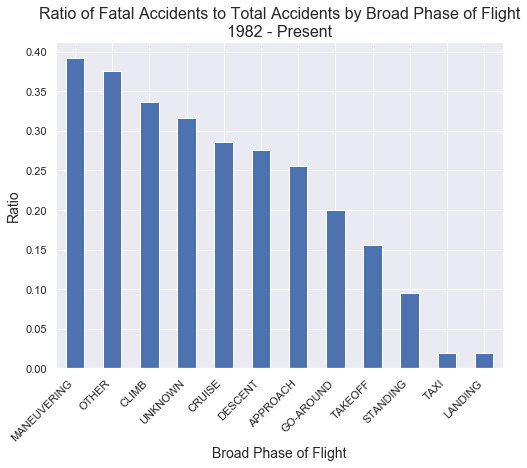

In [24]:
fig,ax = plot_ratio_by_field(df_phase_of_flight,'Broad Phase of Flight','Broad Phase of Flight',sort=True)
a = ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')

In [33]:
df_findings.head()

,ev_id,Aircraft_Key,finding_no,finding_code,finding_description,category_no,subcategory_no,section_no,subsection_no,modifier_no,Cause_Factor,lchg_date,lchg_userid,code
0,20120214X84853,1,1,0106203711,AIRCRAFT-AIRCRAFT OPER/PERF/CAPABILITY-PERFORM...,01,06,20,37,11,C,2012-03-23 18:30:44,SNYG,0106
1,20120214X84853,1,2,0204101544,PERSONNEL ISSUES-ACTION/DECISION-ACTION-INCORR...,02,04,10,15,44,C,2012-03-23 18:30:44,SNYG,0204
2,20081003X65757,1,1,0106202020,AIRCRAFT-AIRCRAFT OPER/PERF/CAPABILITY-PERFORM...,01,06,20,20,20,C,2009-01-18 15:58:33,GROL,0106
3,20081003X65757,1,2,0206304046,PERSONNEL ISSUES-TASK PERFORMANCE-USE OF EQUIP...,02,06,30,40,46,C,2009-01-18 15:58:33,GROL,0206
4,20110716X12058,1,1,0106202020,AIRCRAFT-AIRCRAFT OPER/PERF/CAPABILITY-PERFORM...,01,06,20,20,20,C,2011-08-23 12:36:50,SCHL,0106


In [32]:
df_findings['code'] = df_findings['category_no'] + df_findings['subcategory_no']

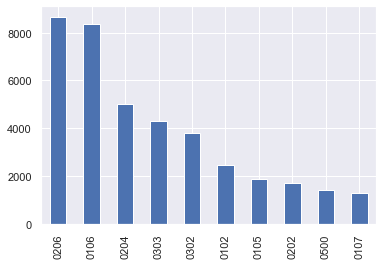

In [34]:
df_findings['code'].value_counts()[:10].plot.bar()

In [27]:
df_findings.head()

,ev_id,Aircraft_Key,finding_no,finding_code,finding_description,category_no,subcategory_no,section_no,subsection_no,modifier_no,Cause_Factor,lchg_date,lchg_userid
0,20120214X84853,1,1,0106203711,AIRCRAFT-AIRCRAFT OPER/PERF/CAPABILITY-PERFORM...,01,06,20,37,11,C,2012-03-23 18:30:44,SNYG
1,20120214X84853,1,2,0204101544,PERSONNEL ISSUES-ACTION/DECISION-ACTION-INCORR...,02,04,10,15,44,C,2012-03-23 18:30:44,SNYG
2,20081003X65757,1,1,0106202020,AIRCRAFT-AIRCRAFT OPER/PERF/CAPABILITY-PERFORM...,01,06,20,20,20,C,2009-01-18 15:58:33,GROL
3,20081003X65757,1,2,0206304046,PERSONNEL ISSUES-TASK PERFORMANCE-USE OF EQUIP...,02,06,30,40,46,C,2009-01-18 15:58:33,GROL
4,20110716X12058,1,1,0106202020,AIRCRAFT-AIRCRAFT OPER/PERF/CAPABILITY-PERFORM...,01,06,20,20,20,C,2011-08-23 12:36:50,SCHL


In [35]:
df_events.head()

,ev_id,ntsb_no,ev_type,ev_date,ev_dow,ev_time,ev_tmzn,ev_city,ev_state,ev_country,ev_site_zipcode,ev_year,ev_month,mid_air,on_ground_collision,latitude,longitude,latlong_acq,apt_name,ev_nr_apt_id,ev_nr_apt_loc,apt_dist,apt_dir,apt_elev,wx_brief_comp,wx_src_iic,wx_obs_time,wx_obs_dir,wx_obs_fac_id,wx_obs_elev,wx_obs_dist,wx_obs_tmzn,light_cond,sky_cond_nonceil,sky_nonceil_ht,sky_ceil_ht,sky_cond_ceil,vis_rvr,vis_rvv,vis_sm,wx_temp,wx_dew_pt,wind_dir_deg,wind_dir_ind,wind_vel_kts,wind_vel_ind,gust_ind,gust_kts,altimeter,wx_dens_alt,wx_int_precip,metar,ev_highest_injury,inj_f_grnd,inj_m_grnd,inj_s_grnd,inj_tot_f,inj_tot_m,inj_tot_n,inj_tot_s,inj_tot_t,invest_agy,ntsb_docket,ntsb_notf_from,ntsb_notf_date,ntsb_notf_tm,fiche_number,lchg_date,lchg_userid,wx_cond_basic,faa_dist_office,far_part
0,20001208X07734,LAX97FA143,ACC,1997-04-02,WE,2016.0,MST,GRAND CANYON,AZ,USA,86023,1997,4,N,N,,,None,,,OFAP,NaN,NaN,NaN,PARP,WFAC,1954.0,180.0,GCN,6606.0,21.0,MST,NDRK,SCAT,3600.0,6000.0,BKN,0.0,0.0,10.0,-2.0,-3.0,0.0,U,0.0,CALM,N,0.0,29.000000,NaN,UNK,None,FATL,0.0,0.0,0.0,2.0,NaN,NaN,NaN,2.0,N,1890.0,None,1997-04-02,1922.0,IMAGE,2000-12-08 12:13:18,DBO,IMC,None,091
1,20021008X05297,CHI02LA299,ACC,2002-09-29,SU,2100.0,CDT,MOORHEAD,MN,USA,56560,2002,9,N,N,465021N,0963947W,None,MOORHEAD MUNICIPAL,JKJ,ONAP,NaN,NaN,917.0,UNK,WFAC,2053.0,47.0,FAR,908.0,9.0,BST,NDRK,CLER,NaN,1300.0,OVC,NaN,NaN,7.0,14.0,12.0,160.0,Y,13.0,SPEC,Y,0.0,29.709999,NaN,None,None,SERS,NaN,NaN,NaN,NaN,1.0,NaN,1.0,2.0,N,13246.0,FAA,2002-10-03,945.0,DMS,2003-04-23 12:26:43,NTSB\MONR,VMC,MINNEAPOLIS FSDO,091
2,20040127X00111,LAX04LA103,ACC,2003-10-12,SU,1640.0,MST,SCOTTSDALE,AZ,USA,85255,2003,10,N,N,333722N,1115438W,None,SCOTTSDALE,SDL,ONAP,NaN,NaN,1510.0,FULL,WFAC,1653.0,NaN,KSDL,1510.0,NaN,MST,DAYL,CLER,NaN,NaN,NONE,NaN,NaN,10.0,33.0,12.0,NaN,None,NaN,CALM,N,NaN,29.889999,NaN,None,None,NONE,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,N,17586.0,FAA,2004-01-22,1215.0,DMS,2005-04-28 14:59:26,NTSB\JOHB,VMC,WP-SDL-FSDO,091
3,20181125X85246,GAA19CA073,ACC,2018-11-25,SU,1320.0,PST,PORTERVILLE,CA,USA,93257,2018,11,N,N,360148N,1190347W,EST,PORTERVILLE MUNI,PTV,ONAP,0.0,327.0,443.0,None,WFAC,2156.0,177.0,KPTV,442.0,0.0,UTC,DAYL,CLER,NaN,NaN,NONE,NaN,NaN,10.0,21.0,12.0,300.0,Y,6.0,SPEC,N,NaN,30.059999,NaN,None,METAR KPTV 252156Z AUTO 30006KT 10SM CLR 21/12...,NONE,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,N,NaN,NTSB_WPR,NaT,NaN,None,2018-12-19 16:51:35,GUTE,VMC,None,091
4,20001213X34369,ANC86LA135,ACC,1986-08-23,SA,1100.0,AKD,TALKEETNA,AK,USA,99676,1986,8,N,N,,,None,,,OFAP,0.0,0.0,0.0,UNK,PILO,0.0,0.0,,0.0,0.0,,DAYL,CLER,0.0,0.0,NONE,0.0,0.0,50.0,10.0,-18.0,0.0,U,0.0,UNK,U,0.0,NaN,NaN,UNK,None,NONE,0.0,0.0,0.0,NaN,NaN,3.0,NaN,NaN,N,891.0,None,1986-08-23,1430.0,31238,2001-01-02 09:14:50,DBO,VMC,None,091


In [50]:
df = df_events[['ev_id','ev_highest_injury']]
df = df.merge(df_aircraft[['ev_id','num_eng']],on='ev_id')
df = df.merge(df_findings,on='ev_id')
# df = df[df['ev_highest_injury']=='FATL']

In [59]:
df_rate = df.groupby(['num_eng','code']).size().unstack(fill_value=0)

In [60]:
df_rate = (df_rate.drop(3.0)
          .drop(4.0)
          .drop(0.0))
df_rate

code,0101,0102,0103,0104,0105,0106,0107,0201,0202,0203,0204,0205,0206,0301,0302,0303,0304,0401,0402,0403,0500
num_eng,,,,,,,,,,,,,,,,,,,,,
1.0,199,1836,348,301,1560,7278,1116,454,2157,702,4171,36,7454,181,3290,3480,74,53,67,92,1184
2.0,34,354,55,30,95,467,105,64,207,75,437,3,630,14,170,260,3,16,21,21,121


In [71]:
df_rate.loc['1.0_rate'] = df_rate.loc[1.0] / df_rate.loc[1.0].sum()

In [72]:
df_rate.loc['2.0_rate'] = df_rate.loc[2.0] / df_rate.loc[2.0].sum()

In [73]:
df_rate

code,0101,0102,0103,0104,0105,0106,0107,0201,0202,0203,0204,0205,0206,0301,0302,0303,0304,0401,0402,0403,0500
num_eng,,,,,,,,,,,,,,,,,,,,,
1.0,199.000000,1836.000000,348.000000,301.000000,1560.000000,7278.000000,1116.000000,454.000000,2157.000000,702.000000,4171.000000,36.000000,7454.000000,181.000000,3290.000000,3480.000000,74.000000,53.000000,67.000000,92.000000,1184.000000
2.0,34.000000,354.000000,55.000000,30.000000,95.000000,467.000000,105.000000,64.000000,207.000000,75.000000,437.000000,3.000000,630.000000,14.000000,170.000000,260.000000,3.000000,16.000000,21.000000,21.000000,121.000000
1.0_rate,0.005523,0.050953,0.009658,0.008353,0.043294,0.201982,0.030972,0.012600,0.059862,0.019482,0.115755,0.000999,0.206866,0.005023,0.091305,0.096578,0.002054,0.001471,0.001859,0.002553,0.032859
2.0_rate,0.010685,0.111251,0.017285,0.009428,0.029855,0.146763,0.032998,0.020113,0.065053,0.023570,0.137335,0.000943,0.197989,0.004400,0.053426,0.081710,0.000943,0.005028,0.006600,0.006600,0.038026


In [76]:
df_rate2 = df_rate.transpose()[['1.0_rate','2.0_rate']]

In [79]:
df_rate2.sort_values('1.0_rate',ascending=False)

num_eng,1.0_rate,2.0_rate
code,,
0206,0.206866,0.197989
0106,0.201982,0.146763
0204,0.115755,0.137335
0303,0.096578,0.081710
0302,0.091305,0.053426
0202,0.059862,0.065053
0102,0.050953,0.111251
0105,0.043294,0.029855
0500,0.032859,0.038026
